# Primal Dual

# Projection onto the simplex



<div class="alert alert-block alert-success">
This notebook implements an algorithm for the projection of a vector $y$ onto the simplex $\Delta$ with
\begin{align}
    \Delta := \Big\{ (x_1,\ldots,x_N)\in \mathbb{R}^N:\, \sum_{n=1}^N x_n =a \quad\text{and}\quad x\geq 0 \Big\}.
\end{align}
    
The implemented algorithm was proposed in: Condat, L. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). 
    
The paper is also available at [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

The algorithm will be tested projecting a random vector $y$ of size $N$ where $y_n \sim \mathcal{U}(-1,2)$ for all $n\in \{1,\ldots,N\}$.

In [1]:
import numpy as np
from numpy import nditer, ndenumerate, zeros, zeros_like, clip, allclose, full, maximum
from numpy.random import default_rng as rng
import time

In [2]:
N = 1000
y = rng(0).uniform(-1,2,N)
a = 1.0

## List version

<div class="alert alert-block alert-info">
First implementation is list-based. It sticks to the algorithm above, and thus it cannot take the advantage that $v$ is the list of positive values of $y$, thus requiring the unnecessary triming in Step 6.
</div>

In [3]:
# Step 1
v = [y[0]]
u = []
ρ = y[0] - a

In [4]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(yₙ)
        else:
            u.extend(v)
            v = [yₙ]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for ι in iter(u):
        if ι > ρ:
            v.append(ι)
            ρ += (ι - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for ı in range(ℓ_v - 1, -1, -1):
        if v[ı] <= ρ:
            ρ += (ρ - v[ı])/(len(v) - 1)
            del v[ı]
    if len(v) >= ℓ_v:
        break

In [5]:
x = clip(y - ρ, 0, None)

In [6]:
v - ρ

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 1

<div class="alert alert-block alert-info">
The following adaptation introduces some array operations to avoid the extra step of clipping negative numbers. Here $v$ is not a set but a boolean array of the same size as $y$. Its cells determine if a cell of $y$ is active in $v$ or not. In the end, $x$ is computed just on the active cells given by $v$.
</div>

In [7]:
# Step 1
ρ = y[0] - a

v = zeros(N, dtype=bool)
x = zeros_like(y)
u = []
v[0] = True

In [8]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( v.sum() + 1 )
        if ρ > yₙ - a:
            v[n] = True
        else:
            u.extend([i[0] for i,j in ndenumerate(v) if j])
            v *= False;    v[n] = True
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v[n] = True
            ρ += (yₙ - ρ)/( v.sum() )
# Step 4
while True:
    ℓ_v = v.sum()
    for i,j in ndenumerate(v):
        if j:
            if y[i[0]] <= ρ:
                ρ += (ρ - y[i[0]])/(v.sum() - 1)
                v[i[0]] = False
    if v.sum() >= ℓ_v:
        break

In [9]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [10]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 2

<div class="alert alert-block alert-info">
The final implementation takes back the original idea of using lists instead of an array of the same size as $y$. In this case, $v$ does not contain values from $y$ but its indeces. This way a sparse representation of $v$ is achieved and $x$ does not go through a clipping step as well.
</div>

In [11]:
# Step 1
ρ = y[0] - a

x = zeros_like(y)
v = [0]
u = []

In [12]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(n)
        else:
            u.extend(v)
            v = [n]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v.append(n)
            ρ += (yₙ - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for i,j in enumerate(v):
        if y[j] <= ρ:
            ρ += (ρ - y[j])/(len(v) - 1)
            del v[i]
    if len(v) >= ℓ_v:
        break

In [13]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [14]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

---

## Performance tests

<div class="alert alert-block alert-warning">
Now we check which routine is the fastest.
</div>

In [15]:
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return clip(y - ρ, 0, None)

def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = zeros(N, dtype=bool)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    x[v] = y[v] - ρ
    return x

In [16]:
%timeit -r 10 -n 200 CondatP_a(y,a,N)

420 µs ± 111 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [17]:
%timeit -r 10 -n 200 CondatP_b(y,a,N)

2.34 ms ± 263 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [18]:
%timeit -r 10 -n 200 CondatP_c(y,a,N)

495 µs ± 122 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


As we can see, the last implementation might be a little faster than the original.

---

## Just-in-time compilation with numba

<div class="alert alert-block alert-warning">
We use numba to speed up the computation time.
</div>

In [19]:
from numba import jit, prange

In [20]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return maximum(y - ρ, 0)

In [21]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = full(N, False)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

In [22]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [23]:
# Run things once for pre-compiling:
CondatP_a(y,a,N), CondatP_b(y,a,N), CondatP_c(y,a,N);

Now we see a clear winner.

In [24]:
%timeit -r 10 -n 20 CondatP_a(y,a,N)

56 µs ± 13.9 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


In [25]:
%timeit -r 10 -n 20 CondatP_b(y,a,N)

15.5 ms ± 2.23 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)


In [26]:
%timeit -r 10 -n 20 CondatP_c(y,a,N)

44.9 µs ± 14.9 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


Finally, a sanity check:

In [27]:
allclose(CondatP_a(y,a,N), CondatP_b(y,a,N)), allclose(CondatP_a(y,a,N), CondatP_c(y,a,N))

(True, True)

---

Now we can finally addapt the code to accept a matrix $\gamma$ as input.

In [28]:
N = 1000
M = 500
γ = rng(0).uniform(-1,2,(N,M))
a = 1.0

In [29]:
y = rng(0).uniform(-1,2,N)
x = zeros_like(γ)

In [30]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,x,a,N):
    if a == 0:
        return x
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            '''if len(v) == 1:
                break'''
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [31]:
CondatP_c(y,x,a,N); # Null test
x = zeros_like(γ)

In [32]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,x,a,N):
    if a == 0:
        return x
    
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [33]:
CondatP_c(y,x,a,N); # Null test

In [34]:
for i in range(N):
    x[i] = CondatP_c(γ[i],x[i],a,M)

In [35]:
# Just checking :)
for i in range(N):
    if x[i].sum() > 2:
        print(i)

26
27
77
94
163
171
194
198
239
252
275
278
308
349
368
405
412
414
497
530
698
734
736
745
762
790
799
812


In [36]:
x.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        , 33.17240125,  9.86861806,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

# Indicator Function and Proximal

In [37]:
# Aliases
from numpy import nditer, ndenumerate, zeros, zeros_like, clip, allclose, full, maximum, linspace, ones
from numpy import log, ceil, inf, absolute, tensordot, sqrt, array
from numpy.linalg import norm
from numpy.random import default_rng as rng
from numba import jit, prange
from scipy.spatial.distance import cdist


# Basic data of the instance
M = 100
N = 200

x, y = linspace(0,1,M), linspace(1,2,N)            # Uniform cloud of points
m, n = ones(M)/M, ones(N)/N                        # Uniform distribution of mass
c = cdist(x[:, np.newaxis],y[:, np.newaxis])**2    # Matrix of squared distances

In [38]:
@jit(nopython=True, fastmath = True)
def indicator_simplex(x, η, axis = 0):
    """
    %
    % This procedure evaluates the indicator function of the constraint set:
    %
    %                  x => 0   AND   1'x = η
    %
    %  - axis ∊ {0,1} --> 'x' is processed block-wise along the specified direction
    %
    %  INPUTS
    % ========
    %  x    - ND array
    %  η    - positive ND array compatible with the blocks of 'x'
    %  axis - integer, direction of block-wise processing
    """
    
    # check the constraint
    u = x.sum(axis)
    mask = True
    for ı in range(u.size):
        if u[ı] < 0:
            mask = False
            break
        if abs(u[ı] - η[ı]) > 1e-4:
            mask = False
            break
            
    # evaluate the indicator function
    return 0.0 if mask else inf

In [39]:
@jit(nopython=True, fastmath = True)
def prox_i(y,m,n, v_1, v_2, tol = 1e-5):
    # z = prox(y,m,n,tol) : Computes proximal of the indicator function of the 
    # intersection of the simpleces governed by m and n, respectively.
    #
    # z satisfies sum(y,1) ~ m' and sum(y,2) ~ n with tolerance `tol`.
    #
    # By default, tol = 1e-5.   
    # Recover size of matrix
    M, N = y.shape
    
    # ε is selected as a small number
    ε = 0.1

    # Define theta as a fixed value
    θ = 2 - ε
    θ̂ = 1/θ

    # Initialise z:
    z = y - 0.5 * (v_1 + v_2)
    
    x_1, x_2 = zeros((2,M,N))
    while indicator_simplex(z, m, 1) + indicator_simplex(z, n, 0) != 0.0:
        γ_1 = θ̂ * v_1 + z
        γ_2 = θ̂ * v_2 + z
        
        x_1.fill(0.0),        x_2.fill(0.0);
        
        for i in range(N):
            #x_1[:,i] = CondatP(γ_1[:,i],x_1[:,i],n[i],M)
            x_1[:,i] = CondatP_c(γ_1[:,i],x_1[:,i],n[i],M)
        for i in range(M):
            x_2[i] = CondatP_c(γ_2[i],x_2[i],m[i],N)
            #x_2[i] = CondatP(γ_2[i],x_2[i],m[i],N)
            
        # Update v_1 using its projection over simplex C_1^m
        v_1 += θ * (z - x_1)
        # Update v_2 using its projection over simplex C_2^n
        v_2 += θ * (z - x_2)
        # Update z
        z = y - 0.5 * (v_1 + v_2)
        
        # The indicator evaluation is too hard for double precision arithmetic.
        # Thus, we relax this condition:
        w = absolute(z)
        if (absolute(w.sum(0) - n)/n < tol).all():     # Check with lower tol
            if (absolute(w.sum(1) - m)/m < tol).all():
                z = w
                break
    return z, v_1, v_2

In [40]:
x, v_1, v_2 = zeros((3,M,N))
indicator_simplex(c, m, 1);    prox_i(x,m,n, v_1, v_2);

# Primal Dual

In [69]:
#@jit(nopython=True, fastmath = True)#, parallel = True)
def primal_dual(c,m,n,iters, true_obj_tol = 1e-4, true_solution = None, save_iter = None):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #Initialise tau
    tau = 0.0001
    
    #Initialise sigma
    sig = 1/(tau*2) - 0.5
    
    #fetch lengths of m and n.
    N = n.size
    M = m.size
    
    #Initialise x
    x = np.zeros((M,N))
    #x[:,0] = m
    #x[0,:] = n
    #x[0,0] = 0.5*(m[-1] + n[-1])
    
    #Initialise y_1 and y_2
    y_1 = zeros((M,N))
    y_2 = zeros((M,N))
    
    y_1[0,:] = n
    y_2[:,0] = m
    
    #Save that objective function
    obj = [np.sum(np.multiply(c,x))]
    
    critical_objectives = []
    
    

    
    # Norm of true solution
    if true_solution is not None:
        true_obj = np.tensordot(c,sol,2).item()
        print(true_obj, " True solution objective.")
        true_obj_crit = 1
        
    start = time.time()
    
    every_iter, every_critical = [], []
    
    
    for k in range(iters):
        #update x
        xnew = x - tau*c - tau*(y_1 + y_2)
        
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        γ_1 = (1/sig)*y_1 + 2*xnew - x
        γ_2 = (1/sig)*y_2 + 2*xnew - x
        
        
        x_1 = zeros_like(γ_1)
        for i in range(M):
            x_1[i] = CondatP_c(γ_1[i],x_1[i],m[i],N)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[:,i] = CondatP_c(γ_2[:,i],x_2[:,i],n[i],M)
            
        
        #update x using the projection over the simplex C_1^m
        y_1new = y_1 + sig*(2*xnew - x) - sig*x_1
  
        #update x using the projection over the simplex C_2^n
        y_2new = y_2 + sig*(2*xnew - x) - sig*x_2
        
        #Reset x,y_1, y_2 for the next iteration
        x = xnew
        y_1 = y_1new
        y_2 = y_2new
        
        dist_true_sol = np.abs(np.tensordot(c,x,2).item() - true_obj)
        
        if true_solution is not None and dist_true_sol <  true_obj_crit:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            print(true_obj_crit, "within true objective in ", end-start ," seconds.", " Iteration ", k, ". Distance to true sol ", mat_fronorm)
            every_critical.append([true_obj_crit, end-start, k, mat_fronorm])
            true_obj_crit *= 0.1
        
        # Check how close we are to the true solution
        if true_solution is not None and dist_true_sol <  true_obj_tol:
            print("Close to true sol break")
            end = time.time()    
            print( end-start , " - total time in seconds.")
            with open('Primal_dual_critical.npy', 'wb') as f:
                        np.save(f, np.array(every_critical))
    
            if save_iter == True:
                with open('Primal_dual_iter.npy', 'wb') as f:
                        np.save(f, np.array(every_iter))
            break
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
    
        if save_iter == True:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            every_iter.append([dist_true_sol, end-start, k, mat_fronorm])
        
    end = time.time()    
    print( end-start , " - total time in seconds.")
    with open('Primal_dual_critical.npy', 'wb') as f:
                np.save(f, np.array(every_critical))
    
    if save_iter == True:
        with open('Primal_dual_iter.npy', 'wb') as f:
                np.save(f, np.array(every_iter))
        
    return x, obj, critical_objectives

In [42]:
import matplotlib.pyplot as plt
import time
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y

t = time.time()
x,obj, _ = primal_dual(c,m,n,500)
elapsed = time.time() - t
print('Time taken for Primal Dual =', elapsed)
print(obj[-1])
#plt.plot(obj)
#plt.imshow(x)

KeyboardInterrupt: 

## Exact Test

In [ ]:
import matplotlib.pyplot as plt
#set parameters accordingly.
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
x, obj, _ = primal_dual(c,m,n,10000)
plt.plot(obj)
print(obj[-1])
print(x)

## Generalised Forward-Backward Splitting

<div class="alert alert-block alert-success">
This implements a generalised forward-backward split approach for the OT problem.
    
The implemented algorithm was proposed in: Raguet. H, Fadili. J, Peyre. G <i>Generalised Forward-Backward Splitting</i>. SIAM Journal on Imaging Sciences. (2013)
    
A preprint of the paper is available at https://arxiv.org/pdf/1108.4404.pdf
</div>

In [75]:
#@jit(nopython=True, fastmath = True)#, parallel = True)
def generalised_forward_backward(c,m,n,iters, collect_obj = False, true_obj_tol = 1e-4, true_solution = None, save_iter = False):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #First compute ?
    mu = np.linalg.norm(c,2)     # 1 -> 10^-1 -> 10^-2 -> ...
    # ? is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # ? does not depend on the current iteration
    gam = 0.0001
    #likewise, we do not require a change in ?
    lam = 1.0;   #1.0
    
    #fetch lengths of m and n.
    N = n.size
    M = m.size
    
    #Initialise x
    #x = np.zeros((M,N))
    #x[:,0] = m
    #x[0,:] = n
    #x[0,0] = 0.5*(m[-1] + n[-1])
    
    #Initialise y_1 and y_2
    v_1 = zeros((M,N))
    v_2 = zeros((M,N))
    
    v_1[0,:] = n
    v_2[:,0] = m
    
    #Initialise x
    x = 0.5*(v_1 + v_2)
    
    #Save that objective function
    if collect_obj == True:
        obj = [np.sum(np.multiply(c,x))]
    
    critical_objectives = []
    
    # Norm of true solution
    if true_solution is not None:
        true_obj = np.tensordot(c,sol,2).item()
        print(true_obj, " True solution objective.")
        true_obj_crit = 1
        
    start = time.time()    
    
    every_iter, every_critical = [], []
    
    for k in range(iters):
    
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        γ_1 = 2*x - v_1 - gam*c
        γ_2 = 2*x - v_2 - gam*c
        
        
        x_1 = zeros_like(γ_1)
        for i in range(M):
            x_1[i] = CondatP_c(γ_1[i],x_1[i],m[i],N)
            #x_1[i] = CondatP(γ_1[i],x_1[i],m[i],N)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[:,i] = CondatP_c(γ_2[:,i],x_2[:,i],n[i],M)
            #x_2[:,i] = CondatP(γ_2[:,i],x_2[:,i],n[i],M)
            
        
        #update x using the projection over the simplex C_1^m
        v_1new = v_1 + lam*(x_1 - x)
  
        #update x using the projection over the simplex C_2^n
        v_2new = v_2  + lam*(x_2 - x)
        
        #Update x,v_1, v_2 for the next iteration
        v_1 = v_1new
        v_2 = v_2new
        x = 0.5*(v_1 + v_2)
        
        #update objective function
        if collect_obj == True:
            obj.append(np.sum(np.multiply(c,x)))
        
        #if true_solution is not None:
        #    print(np.tensordot(c,x,2).item(), "obj", (np.abs(np.tensordot(c,x,2).item() - true_obj)))
            
        dist_true_sol = np.abs(np.tensordot(c,x,2).item() - true_obj)
        
        if true_solution is not None and dist_true_sol <  true_obj_crit:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            print(true_obj_crit, "within true objective in ", end-start ," seconds.", " Iteration ", k, ". Distance to true sol ", mat_fronorm)
            every_critical.append([true_obj_crit, end-start, k, mat_fronorm])
            true_obj_crit *= 0.1
        
        # Check how close we are to the true solution
        if true_solution is not None and dist_true_sol <  true_obj_tol:
            print("Close to true sol break")
            end = time.time()    
            print( end-start , " - total time in seconds.")
            with open('GFB_critical.npy', 'wb') as f:
                        np.save(f, np.array(every_critical))
    
            if save_iter == True:
                with open('GFB_iter.npy', 'wb') as f:
                        np.save(f, np.array(every_iter))
            break
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
    
        if save_iter == True:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            every_iter.append([dist_true_sol, end-start, k, mat_fronorm])
        
    end = time.time()    
    print( end-start , " - total time in seconds.")
    with open('GFB_critical.npy', 'wb') as f:
                np.save(f, np.array(every_critical))
    
    if save_iter == True:
        with open('GFB_iter.npy', 'wb') as f:
                np.save(f, np.array(every_iter))
        
    if collect_obj == True:   
        return x,obj, critical_objectives
    else:
        return x

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
N = len_y


t = time.time()
x, obj, _ = generalised_forward_backward(c,m,n,500, collect_obj = True)
elapsed = time.time() - t
print('Time taken for Forward Backward =', elapsed)

print(obj[-1])
#plt.plot(obj)
#plt.imshow(x)

## Exact Test

In [ ]:
import matplotlib.pyplot as plt
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
x, obj, _ = generalised_forward_backward(c,m,n,10000, collect_obj = True)
plt.plot(obj)
print(obj[-1])
print(x)

# Forward Backward

In [87]:
#@jit(nopython=True, fastmath = True)#, parallel = True)
def forward_backward(c,m,n,iters, collect_obj = False, true_obj_tol = 1e-4, true_solution = None, save_iter = False):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #First compute ?
    μ = np.linalg.norm(c,2)     # 1 -> 10^-1 -> 10^-2 -> ...
    # ? is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # ? does not depend on the current iteration
    γ = 0.0001
    #likewise, we do not require a change in ?
    lam = 1.0;   #1.0
    
    #fetch lengths of m and n.
    N = n.size
    M = m.size
    
    #Initialise x
    x = np.zeros((M,N))
    #x[:,0] = m
    #x[0,:] = n
    #x[0,0] = 0.5*(m[-1] + n[-1])
    
    #Initialise y_1 and y_2
    v_1 = zeros((M,N))
    v_2 = zeros((M,N))
    
    v_1[0,:] = n
    v_2[:,0] = m
    
    #Initialise x
    x = 0.5*(v_1 + v_2)
    
    #Save that objective function
    if collect_obj == True:
        obj = [np.sum(np.multiply(c,x))]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj = np.tensordot(c,sol,2).item()
        print(true_obj, " True solution objective.")
        true_obj_crit = 1
    critical_objectives = []

        
    start = time.time()    
    
    every_iter, every_critical = [], []

    
    for k in range(iters):
        
        # First proximal projection
        y = x - γ * c;
        
        # Proximal operation
        y, v_1, v_2 = prox_i(y,m,n,v_1,v_2)
        
        #update x using the projection over the simplex C
        u = (1-lam)*x  + lam*y
        
        #Update x for the next iteration
        x = u
        
        #update objective function
        if collect_obj == True:
            obj.append(np.sum(np.multiply(c,x)))
        
        #if true_solution is not None:
        #    print(np.tensordot(c,x,2).item(), "obj", (np.abs(np.tensordot(c,x,2).item() - true_obj)))
            
        dist_true_sol = np.abs(np.tensordot(c,x,2).item() - true_obj)
        
        if true_solution is not None and dist_true_sol <  true_obj_crit:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            print(true_obj_crit, "within true objective in ", end-start ," seconds.", " Iteration ", k, ". Distance to true sol ", mat_fronorm)
            every_critical.append([true_obj_crit, end-start, k, mat_fronorm])
            true_obj_crit *= 0.1
        
        # Check how close we are to the true solution
        if true_solution is not None and dist_true_sol <  true_obj_tol:
            print("Close to true sol break")
            end = time.time()    
            print( end-start , " - total time in seconds.")
            with open('FB_critical.npy', 'wb') as f:
                        np.save(f, np.array(every_critical))
    
            if save_iter == True:
                with open('FB_iter.npy', 'wb') as f:
                        np.save(f, np.array(every_iter))
            break
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
    
        if save_iter == True:
            end = time.time()
            mat_fronorm = np.linalg.norm(sol-x, 'fro')
            every_iter.append([dist_true_sol, end-start, k, mat_fronorm])
        
    end = time.time()    
    print( end-start , " - total time in seconds.")
    with open('FB_critical.npy', 'wb') as f:
                np.save(f, np.array(every_critical))
    
    if save_iter == True:
        with open('FB_iter.npy', 'wb') as f:
                np.save(f, np.array(every_iter))
        
    if collect_obj == True:   
        return x,obj, critical_objectives
    else:
        return x

# Exact Test

In [ ]:
import matplotlib.pyplot as plt
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
x, obj, _= forward_backward(c,m,n,10000, collect_obj = True)
plt.plot(obj)
print(obj[-1])
print(x)

## Entropic Regularisation for an Initial Guess

In [ ]:
def entropic_regularisation(m,n,c,iters_max,eps= 0.025, collect_obj = False):
    
    #fetch lengths of m and n.
    N = np.size(n)
    M = np.size(m)
    
    #Gibbs Kernel
    Geps = np.exp(-c/eps)
    
    cons = 1/np.sum(Geps)
    a = np.ones(M)*cons
    b = np.ones(N)*cons
    norm_difference = 100
    obj = []
    Kp = (1/(n + 1e-299)).reshape(-1,1) * Geps
    for i in range(iters_max):
        #anew = np.multiply(m,np.reciprocal(np.matmul(Geps, b)))
        #bnew = np.multiply(n,np.reciprocal(np.matmul(a.T, Geps).T))
        #anew = np.divide(m,np.matmul(Geps, b))
        #bnew = np.divide(n,np.matmul(a.T, Geps).T)
        bnew = np.divide(m, np.dot(Geps.T, a)+1e-299)
        anew = 1. / (np.dot(Kp,bnew)+1e-299)
                
        #anew = np.divide(m, Geps * b)
        #bnew = np.divide(n, (a.T * Geps).T)
        
        
        #x = a * Geps * b.T
        #u = anew * Geps * bnew.T
        x = np.multiply(a, np.multiply(Geps, b.T))
        u = np.multiply(anew, np.multiply(Geps, bnew.T))
        #x = a @ Geps @ b.T
        #u = anew @ Geps @ bnew.T
        
        norm_difference = np.linalg.norm(x-u)
        
        a = anew
        b = bnew
        if collect_obj == True:
            obj.append((np.multiply(c,u)).sum())
    
    if collect_obj == True:
        return x, obj
    else:
        return x

In [ ]:
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
x, obj = entropic_regularisation(m,n,c,100000, collect_obj = True)
plt.plot(obj)
print(obj[-1])
print(x)

In [ ]:
### from https://github.com/rflamary/POT/blob/master/ot/bregman.py ###
def sinkhorn_knopp(a, b, M, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False, log=False, **kwargs):
    r"""
    Solve the entropic regularization optimal transport problem and return the OT matrix
    The function solves the following optimization problem:
    .. math::
        \gamma = arg\min_\gamma <\gamma,M>_F + reg\cdot\Omega(\gamma)
        s.t. \gamma 1 = a
             \gamma^T 1= b
             \gamma\geq 0
    where :
    - M is the (dim_a, dim_b) metric cost matrix
    - :math:`\Omega` is the entropic regularization term :math:`\Omega(\gamma)=\sum_{i,j} \gamma_{i,j}\log(\gamma_{i,j})`
    - a and b are source and target weights (histograms, both sum to 1)
    The algorithm used for solving the problem is the Sinkhorn-Knopp matrix scaling algorithm as proposed in [2]_
    Parameters
    ----------
    a : ndarray, shape (dim_a,)
        samples weights in the source domain
    b : ndarray, shape (dim_b,) or ndarray, shape (dim_b, n_hists)
        samples in the target domain, compute sinkhorn with multiple targets
        and fixed M if b is a matrix (return OT loss + dual variables in log)
    M : ndarray, shape (dim_a, dim_b)
        loss matrix
    reg : float
        Regularization term >0
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshol on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    Returns
    -------
    gamma : ndarray, shape (dim_a, dim_b)
        Optimal transportation matrix for the given parameters
    log : dict
        log dictionary return only if log==True in parameters
    Examples
    --------
    >>> import ot
    >>> a=[.5, .5]
    >>> b=[.5, .5]
    >>> M=[[0., 1.], [1., 0.]]
    >>> ot.sinkhorn(a, b, M, 1)
    array([[0.36552929, 0.13447071],
           [0.13447071, 0.36552929]])
    References
    ----------
    .. [2] M. Cuturi, Sinkhorn Distances : Lightspeed Computation of Optimal Transport, Advances in Neural Information Processing Systems (NIPS) 26, 2013
    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT
    """

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    if len(a) == 0:
        a = np.ones((M.shape[0],), dtype=np.float64) / M.shape[0]
    if len(b) == 0:
        b = np.ones((M.shape[1],), dtype=np.float64) / M.shape[1]

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0

    if log:
        log = {'err': []}

    # we assume that no distances are null except those of the diagonal of
    # distances
    if n_hists:
        u = np.ones((dim_a, n_hists)) / dim_a
        v = np.ones((dim_b, n_hists)) / dim_b
    else:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b

    # print(reg)

    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    # print(np.min(K))
    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / (a+ 1e-299)).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = np.divide(b, (KtransposeU+ 1e-299))
        u = 1. / (np.dot(Kp, v)+ 1e-299)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                np.einsum('ik,ij,jk->jk', u, K, v, out=tmp2)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        cpt = cpt + 1
    if log:
        log['u'] = u
        log['v'] = v

    if n_hists:  # return only loss
        res = np.einsum('ik,ij,jk,ij->k', u, K, v, M)
        if log:
            return res, cpt, log
        else:
            return res, cpt

    else:  # return OT matrix

        if log:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), cpt, log
        else:
            return u.reshape((-1, 1)) * K * v.reshape((1, -1)), cpt, (np.multiply(M,u.reshape((-1, 1)) * K * v.reshape((1, -1)))).sum()


In [ ]:
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
%timeit -r 20 -n 20 sinkhorn_knopp(m,n,c,0.005)

In [ ]:
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y
%timeit -r 1 -n 1 sinkhorn_knopp(m,n,c,0.005)
sinkhorn_knopp(m,n,c,0.005)

In [ ]:
%timeit -r 1 -n 1 sinkhorn_knopp(m,n,c,0.005)

In [ ]:
%timeit -r 1 -n 1 generalised_forward_backward(c,m,n,1000)

In [ ]:
%timeit -r 1 -n 1 primal_dual(c,m,n,1000)

# Dual Entropic Regularisation


In [ ]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
"https://github.com/PythonOT/POT/blob/master/ot/bregman.py"
def screenkhorn(a, b, M, reg, ns_budget=None, nt_budget=None, uniform=False, restricted=True,
                maxiter=10000, maxfun=10000, pgtol=1e-09, verbose=False, log=False):
    r""""
    Screening Sinkhorn Algorithm for Regularized Optimal Transport
    The function solves an approximate dual of Sinkhorn divergence [2] which is written as the following optimization problem:
    ..math::
      (u, v) = \argmin_{u, v} 1_{ns}^T B(u,v) 1_{nt} - <\kappa u, a> - <v/\kappa, b>
      where B(u,v) = \diag(e^u) K \diag(e^v), with K = e^{-M/reg} and
      s.t. e^{u_i} \geq \epsilon / \kappa, for all i \in {1, ..., ns}
           e^{v_j} \geq \epsilon \kappa, for all j \in {1, ..., nt}
      The parameters \kappa and \epsilon are determined w.r.t the couple number budget of points (ns_budget, nt_budget), see Equation (5) in [26]
    Parameters
    ----------
    a : `numpy.ndarray`, shape=(ns,)
        samples weights in the source domain
    b : `numpy.ndarray`, shape=(nt,)
        samples weights in the target domain
    M : `numpy.ndarray`, shape=(ns, nt)
        Cost matrix
    reg : `float`
        Level of the entropy regularisation
    ns_budget : `int`, deafult=None
        Number budget of points to be keeped in the source domain
        If it is None then 50% of the source sample points will be keeped
    nt_budget : `int`, deafult=None
        Number budget of points to be keeped in the target domain
        If it is None then 50% of the target sample points will be keeped
    uniform : `bool`, default=False
        If `True`, the source and target distribution are supposed to be uniform, i.e., a_i = 1 / ns and b_j = 1 / nt
    restricted : `bool`, default=True
         If `True`, a warm-start initialization for the  L-BFGS-B solver
         using a restricted Sinkhorn algorithm with at most 5 iterations
    maxiter : `int`, default=10000
      Maximum number of iterations in LBFGS solver
    maxfun : `int`, default=10000
      Maximum  number of function evaluations in LBFGS solver
    pgtol : `float`, default=1e-09
      Final objective function accuracy in LBFGS solver
    verbose : `bool`, default=False
        If `True`, dispaly informations about the cardinals of the active sets and the paramerters kappa
        and epsilon
    Dependency
    ----------
    To gain more efficiency, screenkhorn needs to call the "Bottleneck" package (https://pypi.org/project/Bottleneck/)
    in the screening pre-processing step. If Bottleneck isn't installed, the following error message appears:
    "Bottleneck module doesn't exist. Install it from https://pypi.org/project/Bottleneck/"
    Returns
    -------
    gamma : `numpy.ndarray`, shape=(ns, nt)
        Screened optimal transportation matrix for the given parameters
    log : `dict`, default=False
      Log dictionary return only if log==True in parameters
    References
    -----------
    .. [26] Alaya M. Z., Bérar M., Gasso G., Rakotomamonjy A. (2019). Screening Sinkhorn Algorithm for Regularized Optimal Transport (NIPS) 33, 2019
    """
    # check if bottleneck module exists
    try:
        import bottleneck
    except ImportError:
        warnings.warn(
            "Bottleneck module is not installed. Install it from https://pypi.org/project/Bottleneck/ for better performance.")
        bottleneck = np

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)
    ns, nt = M.shape

    # by default, we keep only 50% of the sample data points
    if ns_budget is None:
        ns_budget = int(np.floor(0.5 * ns))
    if nt_budget is None:
        nt_budget = int(np.floor(0.5 * nt))

    # calculate the Gibbs kernel
    K = np.empty_like(M)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    def projection(u, epsilon):
        u[u <= epsilon] = epsilon
        return u

    # ----------------------------------------------------------------------------------------------------------------#
    #                                          Step 1: Screening pre-processing                                       #
    # ----------------------------------------------------------------------------------------------------------------#

    if ns_budget == ns and nt_budget == nt:
        # full number of budget points (ns, nt) = (ns_budget, nt_budget)
        Isel = np.ones(ns, dtype=bool)
        Jsel = np.ones(nt, dtype=bool)
        epsilon = 0.0
        kappa = 1.0

        cst_u = 0.
        cst_v = 0.

        bounds_u = [(0.0, np.inf)] * ns
        bounds_v = [(0.0, np.inf)] * nt

        a_I = a
        b_J = b
        K_IJ = K
        K_IJc = []
        K_IcJ = []

        vec_eps_IJc = np.zeros(nt)
        vec_eps_IcJ = np.zeros(ns)

    else:
        # sum of rows and columns of K
        K_sum_cols = K.sum(axis=1)
        K_sum_rows = K.sum(axis=0)

        if uniform:
            if ns / ns_budget < 4:
                aK_sort = np.sort(K_sum_cols)
                epsilon_u_square = a[0] / aK_sort[ns_budget - 1]
            else:
                aK_sort = bottleneck.partition(K_sum_cols, ns_budget - 1)[ns_budget - 1]
                epsilon_u_square = a[0] / aK_sort

            if nt / nt_budget < 4:
                bK_sort = np.sort(K_sum_rows)
                epsilon_v_square = b[0] / bK_sort[nt_budget - 1]
            else:
                bK_sort = bottleneck.partition(K_sum_rows, nt_budget - 1)[nt_budget - 1]
                epsilon_v_square = b[0] / bK_sort
        else:
            aK = a / K_sum_cols
            bK = b / K_sum_rows

            aK_sort = np.sort(aK)[::-1]
            epsilon_u_square = aK_sort[ns_budget - 1]

            bK_sort = np.sort(bK)[::-1]
            epsilon_v_square = bK_sort[nt_budget - 1]

        # active sets I and J (see Lemma 1 in [26])
        Isel = a >= epsilon_u_square * K_sum_cols
        Jsel = b >= epsilon_v_square * K_sum_rows

        if sum(Isel) != ns_budget:
            if uniform:
                aK = a / K_sum_cols
                aK_sort = np.sort(aK)[::-1]
            epsilon_u_square = aK_sort[ns_budget - 1:ns_budget + 1].mean()
            Isel = a >= epsilon_u_square * K_sum_cols
            ns_budget = sum(Isel)

        if sum(Jsel) != nt_budget:
            if uniform:
                bK = b / K_sum_rows
                bK_sort = np.sort(bK)[::-1]
            epsilon_v_square = bK_sort[nt_budget - 1:nt_budget + 1].mean()
            Jsel = b >= epsilon_v_square * K_sum_rows
            nt_budget = sum(Jsel)

        epsilon = (epsilon_u_square * epsilon_v_square) ** (1 / 4)
        kappa = (epsilon_v_square / epsilon_u_square) ** (1 / 2)

        if verbose:
            print("epsilon = %s\n" % epsilon)
            print("kappa = %s\n" % kappa)
            print('Cardinality of selected points: |Isel| = %s \t |Jsel| = %s \n' % (sum(Isel), sum(Jsel)))

        # Ic, Jc: complementary of the active sets I and J
        Ic = ~Isel
        Jc = ~Jsel

        K_IJ = K[np.ix_(Isel, Jsel)]
        K_IcJ = K[np.ix_(Ic, Jsel)]
        K_IJc = K[np.ix_(Isel, Jc)]

        K_min = K_IJ.min()
        if K_min == 0:
            K_min = np.finfo(float).tiny

        # a_I, b_J, a_Ic, b_Jc
        a_I = a[Isel]
        b_J = b[Jsel]
        if not uniform:
            a_I_min = a_I.min()
            a_I_max = a_I.max()
            b_J_max = b_J.max()
            b_J_min = b_J.min()
        else:
            a_I_min = a_I[0]
            a_I_max = a_I[0]
            b_J_max = b_J[0]
            b_J_min = b_J[0]

        # box constraints in L-BFGS-B (see Proposition 1 in [26])
        bounds_u = [(max(a_I_min / ((nt - nt_budget) * epsilon + nt_budget * (b_J_max / (
                    ns * epsilon * kappa * K_min))), epsilon / kappa), a_I_max / (nt * epsilon * K_min))] * ns_budget

        bounds_v = [(
            max(b_J_min / ((ns - ns_budget) * epsilon + ns_budget * (kappa * a_I_max / (nt * epsilon * K_min))),
                epsilon * kappa), b_J_max / (ns * epsilon * K_min))] * nt_budget

        # pre-calculated constants for the objective
        vec_eps_IJc = epsilon * kappa * (K_IJc * np.ones(nt - nt_budget).reshape((1, -1))).sum(axis=1)
        vec_eps_IcJ = (epsilon / kappa) * (np.ones(ns - ns_budget).reshape((-1, 1)) * K_IcJ).sum(axis=0)

    # initialisation
    u0 = np.full(ns_budget, (1. / ns_budget) + epsilon / kappa)
    v0 = np.full(nt_budget, (1. / nt_budget) + epsilon * kappa)

    # pre-calculed constants for Restricted Sinkhorn (see Algorithm 1 in supplementary of [26])
    if restricted:
        if ns_budget != ns or nt_budget != nt:
            cst_u = kappa * epsilon * K_IJc.sum(axis=1)
            cst_v = epsilon * K_IcJ.sum(axis=0) / kappa

        cpt = 1
        while cpt < 5:  # 5 iterations
            K_IJ_v = np.dot(K_IJ.T, u0) + cst_v
            v0 = b_J / (kappa * K_IJ_v)
            KIJ_u = np.dot(K_IJ, v0) + cst_u
            u0 = (kappa * a_I) / KIJ_u
            cpt += 1

        u0 = projection(u0, epsilon / kappa)
        v0 = projection(v0, epsilon * kappa)

    else:
        u0 = u0
        v0 = v0

    def restricted_sinkhorn(usc, vsc, max_iter=5):
        """
        Restricted Sinkhorn Algorithm as a warm-start initialized point for L-BFGS-B (see Algorithm 1 in supplementary of [26])
        """
        cpt = 1
        while cpt < max_iter:
            K_IJ_v = np.dot(K_IJ.T, usc) + cst_v
            vsc = b_J / (kappa * K_IJ_v)
            KIJ_u = np.dot(K_IJ, vsc) + cst_u
            usc = (kappa * a_I) / KIJ_u
            cpt += 1

        usc = projection(usc, epsilon / kappa)
        vsc = projection(vsc, epsilon * kappa)

        return usc, vsc

    def screened_obj(usc, vsc):
        part_IJ = np.dot(np.dot(usc, K_IJ), vsc) - kappa * np.dot(a_I, np.log(usc)) - (1. / kappa) * np.dot(b_J,
                                                                                                            np.log(vsc))
        part_IJc = np.dot(usc, vec_eps_IJc)
        part_IcJ = np.dot(vec_eps_IcJ, vsc)
        psi_epsilon = part_IJ + part_IJc + part_IcJ
        return psi_epsilon

    def screened_grad(usc, vsc):
        # gradients of Psi_(kappa,epsilon) w.r.t u and v
        grad_u = np.dot(K_IJ, vsc) + vec_eps_IJc - kappa * a_I / usc
        grad_v = np.dot(K_IJ.T, usc) + vec_eps_IcJ - (1. / kappa) * b_J / vsc
        return grad_u, grad_v

    def bfgspost(theta):
        u = theta[:ns_budget]
        v = theta[ns_budget:]
        # objective
        f = screened_obj(u, v)
        # gradient
        g_u, g_v = screened_grad(u, v)
        g = np.hstack([g_u, g_v])
        return f, g

    # ----------------------------------------------------------------------------------------------------------------#
    #                                           Step 2: L-BFGS-B solver                                              #
    # ----------------------------------------------------------------------------------------------------------------#

    u0, v0 = restricted_sinkhorn(u0, v0)
    theta0 = np.hstack([u0, v0])

    bounds = bounds_u + bounds_v  # constraint bounds

    def obj(theta):
        return bfgspost(theta)

    theta, _, _ = fmin_l_bfgs_b(func=obj,
                                x0=theta0,
                                bounds=bounds,
                                maxfun=maxfun,
                                pgtol=pgtol,
                                maxiter=maxiter)

    usc = theta[:ns_budget] #dual variables u and v.
    vsc = theta[ns_budget:]

    usc_full = np.full(ns, epsilon / kappa)
    vsc_full = np.full(nt, epsilon * kappa)
    usc_full[Isel] = usc
    vsc_full[Jsel] = vsc
    
    #u = e^{f/reg} 
    f = np.log(usc)*reg
    g = np.log(vsc)*reg
    
    
    
    if log:
        log = {}
        log['u'] = usc_full
        log['v'] = vsc_full
        log['Isel'] = Isel
        log['Jsel'] = Jsel

    gamma = usc_full[:, None] * K * vsc_full[None, :]
    gamma = gamma / gamma.sum()

    if log:
        return gamma, log
    else:
        return gamma, f, g

In [ ]:
#NOT WORKING

In [ ]:
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])

In [ ]:
x = screenkhorn(m,n,c,0.005,ns_budget = M,nt_budget = N)
print(x)

In [ ]:
x = sinkhorn_knopp(m,n,c,0.005)
print(x)

# Initial Guess Primal Dual

In [ ]:
#@jit(nopython=True, fastmath = True)#, parallel = True)
def primal_dual_ER_init(c,m,n,tau,iters,x,y_1,y_2):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #Initialise tau
    #tau = 0.0001
    
    #Initialise sigma
    sig = 1/(tau*2) - 0.5
    
    #fetch lengths of m and n.
    N = n.size
    M = m.size
    
#     #Initialise x
#     x = np.zeros((M,N))
#     x[:,0] = m
#     x[0,:] = n
#     x[0,0] = 0.5*(m[-1] + n[-1])
    
#     #Initialise y_1 and y_2
#     y_1 = zeros((M,N))
#     y_2 = zeros((M,N))
    
#     y_1[0,:] = n
#     y_2[:,0] = m
    
    #Save that objective function
    obj = [np.sum(np.multiply(c,x))]
    
    
    for k in range(iters):
        #update x
        xnew = x - tau*c - tau * (y_1 + y_2)
        
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        γ_1 = (1/sig)*y_1 + 2*xnew - x
        γ_2 = (1/sig)*y_2 + 2*xnew - x
        
        
        x_1 = zeros_like(γ_1)
        for i in range(M):
            x_1[i] = CondatP_c(γ_1[i],x_1[i],m[i],N)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[:,i] = CondatP_c(γ_2[:,i],x_2[:,i],n[i],M)
            
        
        #update x using the projection over the simplex C_1^m
        y_1new = y_1 + sig*(2*xnew - x) - sig*x_1
  
        #update x using the projection over the simplex C_2^n
        y_2new = y_2 + sig*(2*xnew - x) - sig*x_2
        
        #Reset x,y_1, y_2 for the next iteration
        x = xnew
        y_1 = y_1new
        y_2 = y_2new
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
        
    return x,obj

In [ ]:
x = sinkhorn_knopp(m,n,c,0.005)[0]
print(x)
print(c)
[gam,f,g] = screenkhorn(m,n,c,0.005,ns_budget = M,nt_budget = N)


In [ ]:
[x,obj] = primal_dual_ER_init(c,m,n,0.01,100,x,f,g)
plt.plot(obj)
print(obj[-1])
print(x)

In [ ]:
[x,obj] = primal_dual(c,m,n,100)
plt.plot(obj)
print(obj[-1])
print(x)

In [ ]:
tau = 0.0001
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y

t = time.time()
[x,obj] = primal_dual(c,m,n,500)
elapsed = time.time() - t
print('Time taken for Primal Dual =', elapsed)
plt.plot(obj)
print(obj[-1])

In [ ]:
tau = 0.0001
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y

t = time.time()
x = sinkhorn_knopp(m,n,c,0.005)[0]
[gam,f,g] = screenkhorn(m,n,c,0.005,ns_budget = M,nt_budget = N)
[x,obj] = primal_dual_ER_init(c,m,n,tau,500,x,f,g)
elapsed = time.time() - t
print('Time taken for Primal Dual with Initialisation =', elapsed)
plt.plot(obj)
print(obj[-1])

# DOTmark test

In [44]:
m, n = np.load('Exact/data32_1001-data64_1001_p=2_m.npy'), np.load('Exact/data32_1001-data64_1001_p=2_n.npy') 
M = m.size
N = n.size

c, sol = np.load('Exact/data32_1001-data64_1001_p=2_Cost.npy'), np.load('Exact/data32_1001-data64_1001_p=2_Sol.npy')

### Generalised Forward Backward

0.3548703355051073  True solution objective.
1 within true objective in  0.7534282207489014  seconds.  Iteration  0 . Distance to true sol  0.05260795806723873
0.1 within true objective in  1.5220942497253418  seconds.  Iteration  1 . Distance to true sol  0.03866169563159199
37.92667293548584  - total time in seconds.


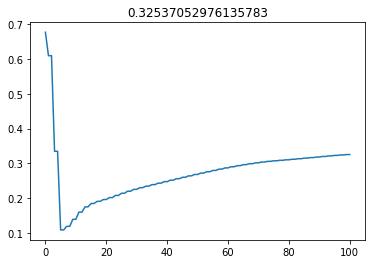

In [81]:
x, obj, critical_objsGFP = generalised_forward_backward(c,m,n, 50, collect_obj = True, true_obj_tol = 1e-3 ,true_solution = sol, save_iter = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

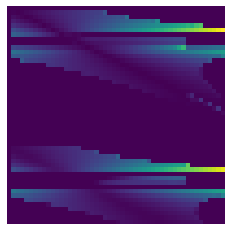

In [82]:
plt.imshow((x * c)[:50,:50]);  plt.axis('off');  plt.show()

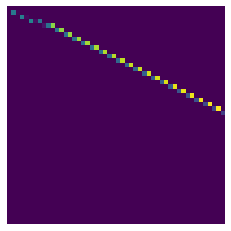

In [83]:
plt.imshow((sol * c)[:50,:50]);  plt.axis('off');  plt.show()

### Primal-Dual

0.3548703355051073  True solution objective.
1 within true objective in  1.6880531311035156  seconds.  Iteration  1 . Distance to true sol  0.032920085496105575
9.297522783279419  - total time in seconds.


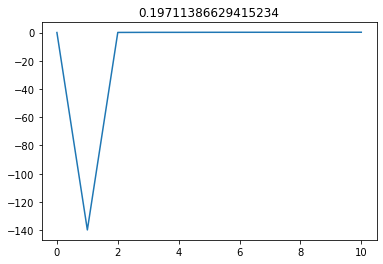

In [70]:
x, obj, critical_objsPD = primal_dual(c,m,n, 10, true_obj_tol = 1e-7, true_solution = sol, save_iter = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

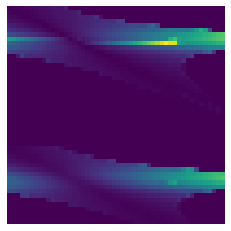

In [61]:
plt.imshow((x * c)[:50,:50]);  plt.axis('off');  plt.show()

### Forward-Backward

0.3548703355051073  True solution objective.
1 within true objective in  334.13358521461487  seconds.  Iteration  0 . Distance to true sol  0.03269884531751918
Close to true sol break
334.1496584415436  - total time in seconds.
334.1506972312927  - total time in seconds.


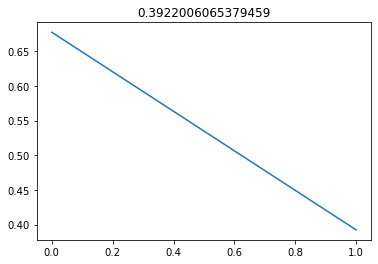

In [92]:
x, obj, critical_objsFB = forward_backward(c,m,n,10, collect_obj = True, true_obj_tol = 1e-1, true_solution = sol, save_iter = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

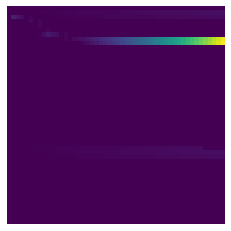

In [93]:
plt.imshow((x * c)[:50,:50]);  plt.axis('off');  plt.show()

## Plot the critical timing

In [ ]:
plt.figure(figsize = (10,8))

plt.plot([x[1] for x in critical_objsGFP], label = "Generalised FB")
plt.plot([2.699, 4.214, 33.703, 1472.609, 13224.280, 36507.167], label = "Primal-Dual")
plt.plot([9.899, 122.328, 256.376])
plt.yscale("log")
plt.xticks(np.arange(6), ['$10^{0}$','$10^{-1}$', '$10^{-2}$', '$10^{-3}$', '$10^{-4}$', '$10^{-5}$'])
plt.xlabel("Tolerance Achieved")
plt.ylabel("Time in Seconds")

plt.legend()
plt.savefig('GFP-PDG_tol.jpeg')
plt.show()

In [94]:
with open('FB_critical.npy', 'rb') as f:
    a = np.load(f)
a

array([[1.00000000e+00, 3.34133585e+02, 0.00000000e+00, 3.26988453e-02]])

In [95]:
with open('FB_iter.npy', 'rb') as f:
    a = np.load(f)
a

array([], dtype=float64)